In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

# 파일 경로 입력
zip_file_name = '/content/drive/MyDrive/multi_class_classification_test2/animals.zip'

# 압축 해제할 경로 입력
extraction_dir = '/content/dataset'

# 압축 해제
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

In [4]:
from imutils import paths

search_dir = "/content/dataset/animals"
search_dir_baboon = "/content/dataset/animals/baboon"
search_dir_chimpanzee = "/content/dataset/animals/chimpanzee"
search_dir_gorilla = "/content/dataset/animals/gorilla"
search_dir_monkey = "/content/dataset/animals/monkey"

image_paths = sorted(
    list(paths.list_images(search_dir))
)
image_paths_baboon = sorted(
    list(paths.list_images(search_dir_baboon))
)
image_paths_chimpanzee = sorted(
    list(paths.list_images(search_dir_chimpanzee))
)
image_paths_gorilla = sorted(
    list(paths.list_images(search_dir_gorilla))
)
image_paths_monkey = sorted(
    list(paths.list_images(search_dir_monkey))
)

print(">>> total images =", len(image_paths))
print(">>> baboon images =", len(image_paths_baboon))
print(">>> chimpanzee images =", len(image_paths_chimpanzee))
print(">>> gorilla images =", len(image_paths_gorilla))
print(">>> monkey images =", len(image_paths_monkey))

>>> total images = 4000
>>> baboon images = 1000
>>> chimpanzee images = 1000
>>> gorilla images = 1000
>>> monkey images = 1000


In [5]:
import os
import cv2
from tqdm import tqdm

image_dim = (180, 180, 3)

images = []
labels = []
for image_path in tqdm(image_paths):
    image = cv2.imread(image_path)

    image = cv2.resize(
        image, (image_dim[1], image_dim[0])
    )
    images.append(image)

    label = image_path.split(os.path.sep)[-2]
    labels.append([label])

print(">>> images count =", len(images))

100%|██████████| 4000/4000 [00:16<00:00, 237.78it/s]

>>> images count = 4000


In [6]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

images = np.array(images, dtype='float32') / 255.0
labels = np.array(labels)

mlb = MultiLabelBinarizer()
enc_labels = mlb.fit_transform(labels)

print(f'label shape = {labels}')
print(f'mlb 값 : {mlb}')
print(f'enc_labels : {enc_labels}')
print(">>> classes name =", mlb.classes_)

label shape = [['baboon']
 ['baboon']
 ['baboon']
 ...
 ['monkey']
 ['monkey']
 ['monkey']]
mlb 값 : MultiLabelBinarizer()
enc_labels : [[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]
>>> classes name = ['baboon' 'chimpanzee' 'gorilla' 'monkey']


In [ ]:
from sklearn.model_selection import train_test_split

seed = 47

(x_train, x_test, y_train, y_test) = train_test_split(
    images, enc_labels, test_size=0.2, random_state=seed
)
print(">> train test shape = {} {}".format(
    x_train.shape, y_train.shape)
)

>> train test shape = (3200, 180, 180, 3) (3200, 4)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense

class Classifier:
	def build(width, height, depth, classes):
		model = Sequential()
		input_shape = (height, width, depth)

		model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
		model.add(Activation('relu'))
		model.add(BatchNormalization(axis=-1))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))

		model.add(Conv2D(64, (3, 3), padding='same'))
		model.add(Activation('relu'))
		model.add(BatchNormalization(axis=-1))
		model.add(Conv2D(64, (3, 3), padding='same'))
		model.add(Activation('relu'))
		model.add(BatchNormalization(axis=-1))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		model.add(Conv2D(128, (3, 3), padding='same'))
		model.add(Activation('relu'))
		model.add(BatchNormalization(axis=-1))
		model.add(Conv2D(128, (3, 3), padding='same'))
		model.add(Activation('relu'))
		model.add(BatchNormalization(axis=-1))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		model.add(Conv2D(256, (3, 3), padding='same'))
		model.add(Activation('relu'))
		model.add(BatchNormalization(axis=-1))
		model.add(Conv2D(256, (3, 3), padding='same'))
		model.add(Activation('relu'))
		model.add(BatchNormalization(axis=-1))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		model.add(Flatten())
		model.add(Dense(2048))
		model.add(Activation('relu'))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		model.add(Dense(classes))
		model.add(Activation('softmax'))
		return model

model = Classifier.build(
    width=image_dim[1], height=image_dim[0], depth=image_dim[2],
    classes=len(mlb.classes_)
)

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

batch_size = 128
epoch = 200
learning_rate = 1e-3


optimizer = Adam(
    learning_rate=learning_rate,
    beta_1=0.9, beta_2=0.999, epsilon=1e-07
)

loss = CategoricalCrossentropy(from_logits=False)

model.compile(
    loss=loss,
    optimizer=optimizer,
	metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)

In [ ]:
history = model.fit_generator(
	aug.flow(
        x_train, y_train, batch_size=batch_size
    ),
	validation_data=(x_test, y_test),
	steps_per_epoch=len(x_train) // batch_size,
	epochs=epoch, verbose=1
)

<ipython-input-10-38b69b003586>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/200
25/25 [==============================] - 38s 846ms/step - loss: 2.1529 - accuracy: 0.3794 - val_loss: 2.1562 - val_accuracy: 0.2500
Epoch 2/200
25/25 [==============================] - 21s 853ms/step - loss: 1.5484 - accuracy: 0.4241 - val_loss: 2.4028 - val_accuracy: 0.2500
Epoch 3/200
25/25 [==============================] - 21s 853ms/step - loss: 1.4261 - accuracy: 0.4531 - val_loss: 3.7060 - val_accuracy: 0.2500
Epoch 4/200
25/25 [==============================] - 22s 855ms/step - loss: 1.3516 - accuracy: 0.4672 - val_loss: 2.1490 - val_accuracy: 0.2300
Epoch 5/200
25/25 [==============================] - 22s 857ms/step - loss: 1.3164 - accuracy: 0.4856 - val_loss: 2.9658 - val_accuracy: 0.2500
Epoch 6/200
25/25 [==============================] - 22s 856ms/step - loss: 1.2946 - accuracy: 0.5019 - val_loss: 2.8915 - val_accuracy: 0.2350
Epoch 7/200
25/25 [==============================] - 22s 857ms/step - loss: 1.2187 - accuracy: 0.5113 - val_loss: 3.5391 - val_accuracy:

In [7]:
test_image_paths = sorted(
    list(
        paths.list_images("/content/dataset/images")
    )
)
print(">>> test image path =", test_image_paths)

>>> test image path = ['/content/dataset/images/baboon_001.jpg', '/content/dataset/images/baboon_002.jpg', '/content/dataset/images/baboon_003.jpg', '/content/dataset/images/chimpanzee_001.jpg', '/content/dataset/images/chimpanzee_002.jpg', '/content/dataset/images/chimpanzee_003.jpg', '/content/dataset/images/gorilla_001.jpg', '/content/dataset/images/gorilla_002.jpg', '/content/dataset/images/gorilla_003.jpg', '/content/dataset/images/monkey_001.jpg', '/content/dataset/images/monkey_002.jpg', '/content/dataset/images/monkey_003.jpg']


In [8]:
from tensorflow.keras.models import load_model

# 모델 로드
model = load_model('/content/drive/MyDrive/multi_class_classification_test2/model.keras')

>>> class index = ['baboon' 'chimpanzee' 'gorilla' 'monkey']


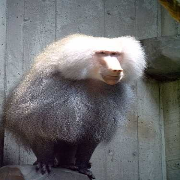

1/1 [==============================] - 2s 2s/step
[0.014 0.    0.    0.986]
>>> predict class = monkey
>>> actual class = baboon_001.jpg


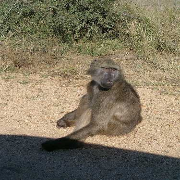

1/1 [==============================] - 0s 22ms/step
[0.996 0.    0.    0.004]
>>> predict class = baboon
>>> actual class = baboon_002.jpg


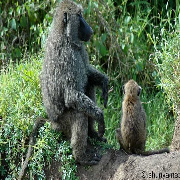

1/1 [==============================] - 0s 21ms/step
[0.968 0.001 0.024 0.007]
>>> predict class = baboon
>>> actual class = baboon_003.jpg


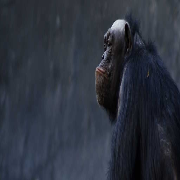

1/1 [==============================] - 0s 20ms/step
[0.    0.991 0.    0.009]
>>> predict class = chimpanzee
>>> actual class = chimpanzee_001.jpg


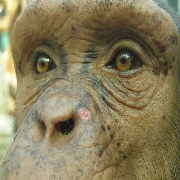

1/1 [==============================] - 0s 21ms/step
[0. 0. 0. 1.]
>>> predict class = monkey
>>> actual class = chimpanzee_002.jpg


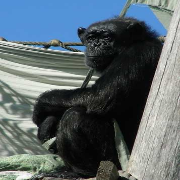

1/1 [==============================] - 0s 21ms/step
[0.001 0.003 0.935 0.061]
>>> predict class = gorilla
>>> actual class = chimpanzee_003.jpg


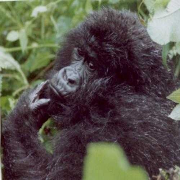

1/1 [==============================] - 0s 21ms/step
[0. 0. 0. 1.]
>>> predict class = monkey
>>> actual class = gorilla_001.jpg


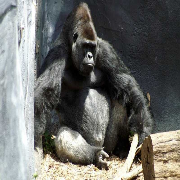

1/1 [==============================] - 0s 21ms/step
[0.038 0.    0.008 0.954]
>>> predict class = monkey
>>> actual class = gorilla_002.jpg


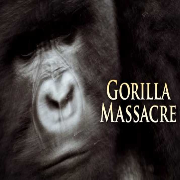

1/1 [==============================] - 0s 21ms/step
[0. 0. 0. 1.]
>>> predict class = monkey
>>> actual class = gorilla_003.jpg


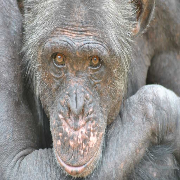

1/1 [==============================] - 0s 21ms/step
[0. 0. 0. 1.]
>>> predict class = monkey
>>> actual class = monkey_001.jpg


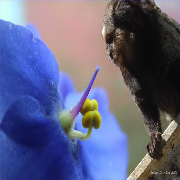

1/1 [==============================] - 0s 20ms/step
[0. 0. 0. 1.]
>>> predict class = monkey
>>> actual class = monkey_002.jpg


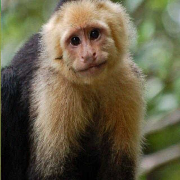

1/1 [==============================] - 0s 21ms/step
[0. 0. 0. 1.]
>>> predict class = monkey
>>> actual class = monkey_003.jpg


In [9]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

print(">>> class index =", mlb.classes_)

for image_path in test_image_paths:
    test_image = cv2.imread(image_path)

    if test_image is None:
        print(f"Error loading image {image_path}")
        continue

    # 이미지 리사이징
    test_image = cv2.resize(test_image, (180, 180))  # 모델이 예상하는 크기로 조정

    cv2_imshow(test_image)

    # 이미지 전처리
    test_image = test_image.astype("float32") / 255.0
    test_image = np.expand_dims(test_image, axis=0)

    try:
        # 모델 예측
        proba = model.predict(test_image)[0]
        print(np.round(proba, 3))
        idx = np.argmax(proba)
        print(">>> predict class =", mlb.classes_[idx])
        print(f">>> actual class = {image_path.split(os.path.sep)[-1]}")
    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")

In [ ]:
# 모델 전체 저장
model.save('/content/drive/MyDrive/multi_class_classification_test2/model.keras')


In [ ]:
# 가중치만 저장
model.save_weights('/content/drive/MyDrive/multi_class_classification_test2/weights.keras')

In [ ]:
# # 모델 구조를 정의한 후
# model = Classifier.build(width=180, height=180, depth=3, classes=len(mlb.classes_))

# # 저장된 가중치 로드
# model.load_weights('path_to_your_model/weights.keras')